In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import pyarrow.parquet as pq

In [42]:
DATA_PATH = r"C:\Users\zoopy\code\review-assist\data\yelp_academic_dataset_review.json"
WRITE_PATH = r"C:\Users\zoopy\code\review-assist\data\yelp_academic_dataset_review_short.json"
FINAL_WRITE_PATH = r"C:\Users\zoopy\code\review-assist\data\yelp_restaurant_reviews.parquet"

In [34]:
with open(DATA_PATH, mode='r', encoding='utf8') as in_file, \
    open(WRITE_PATH, mode='w', encoding='utf8') as out_file:
        for i in range(250000):
            out_file.write(next(in_file))

In [35]:
df = pd.read_json(WRITE_PATH, lines=True)

In [36]:
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
249995,PxrEvgINy-nX2YPTCB8m-g,Iu1sPndxNFviDXe9FF1eDA,iWE3yZIfQunl1nXevPZrhA,3,1,0,0,Ambience GOOD\nMusic - Odd 90's Top 40 - inclu...,2013-11-07 22:16:53
249996,9au4kf9xXkLc7xf9GgoR8A,R4dhP_IfMfZa9eOwzaH17A,nOyphAl0JQ8JrvNi93pclQ,5,1,0,0,I am updating my review! I have been going to ...,2014-03-11 04:30:54
249997,ZL5be9i-wI2acWR5F5BjGg,klm0BR4IQgU0sdO-_1UuKg,Cr-uaPrfvG7tvqzLGAGErA,5,1,0,1,"I've been to a lot of sushi places, and this i...",2010-07-25 09:56:25
249998,c_YhfqoUOKpKBJDGH_TR9Q,9-z8DCVGGVhgwU-etc4zIA,GBTPC53ZrG1ZBY3DT8Mbcw,4,0,0,1,"Prior to visiting new orleans, I asked around ...",2016-02-04 14:16:13


In [44]:
df["stars"].value_counts()

5    110247
4     62542
3     28060
1     26850
2     19745
Name: stars, dtype: int64

In [45]:
df.count()

review_id      247444
user_id        247444
business_id    247444
stars          247444
useful         247444
funny          247444
cool           247444
text           247444
date           247444
text_length    247444
dtype: int64

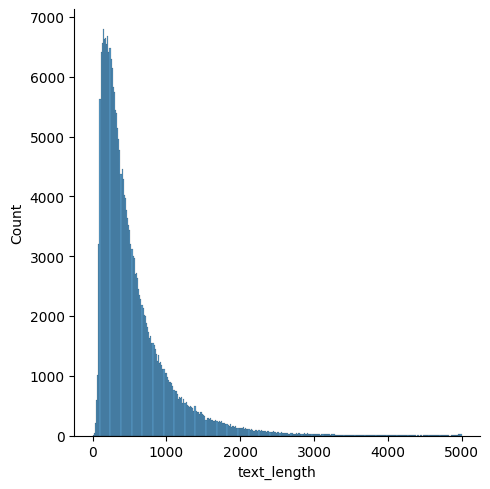

In [38]:
df['text_length'] = df['text'].apply(len)
sns.displot(df,x='text_length')

In [39]:
df = df.loc[df['text_length'] <= 2500]

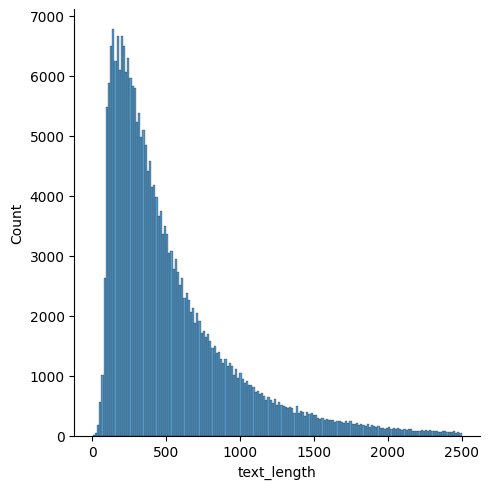

In [40]:
sns.displot(df,x='text_length')

In [43]:
df.to_parquet(FINAL_WRITE_PATH)